### 0 - MODULES

all modules, libraries, imports and constant used in this program

In [487]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

FLIGHT_DELAY_INPUT = "FlightSchedule.csv" 
TOL = 0.0001

<h3> 1 - READ FLIGHT DETAIL</h3>

This function reads the flight detail from the csv file, <br> the file is organized as:
<ol>
<li>FL_DATE: day of the flight in format YYYY-mm-dd.</li>
<li>TAIL_NUM: aircraft registration number, unique to a single aircraft.</li>
<li>UNIQUE_CARRIER: flight carrier id.</li>
<li>FL_NUM: number of the flight</li>
<li>ORIGIN: departure airport code.</li>
<li>DEST: destination airport code.</li>
<li>CRS_DEP_TIME: scheduled departure time (local time: HHMM) shown in the carriers’ Computerized
Reservations Systems (CRS)</li>
<li>DEP_TIME: actual departure time (local time: HHMM)</li>
<li>DEP_DELAY: overall delay at departure. Difference in minutes (floating point number) between scheduled and actual departure time. Early departures set to 0.</li>
<li>CRS_ARR_TIME: scheduled arrival time (local time: HHMM) shown in the carriers’ Computerized
Reservations Systems (CRS)</li>
<li>ARR_TIME: actual arrival time (local time: HHMM)</li>
<li>ARR_DELAY: overall delay. Difference in minutes (floating point number) between scheduled and
actual arrival time. Early arrivals show negative numbers.</li>
<li>CARRIER_DELAY: delay in minutes (floating point number) caused by the carrier</li>
<li>WEATHER_DELAY: delay in minutes (floating point number) caused by the weather.</li>
<li>NAS_DELAY: delay in minutes (floating point number) caused by the National Air System (NAS).</li>
<li>SECURITY_DELAY: delay in minutes (floating point number) caused by the security</li>
<li>LATE_AIRCRAFT_DELAY: delay in minutes (floating point number) caused by the aircraft</li>
<li>There are some other fields in this dataset</li>
</ol>
Returns the pandas dataFrame filtering out the last column

In [488]:
import numpy as np
def readFileInputFlight(file:str)->pd.DataFrame:
    return pd.read_csv(file).iloc[:, :-1]

### 2 - ANSWER THE FOLLOWING QUESTION

Use the info() and describe() methods to analyze how your records are distributed. <br>
Before continuing, try to answer the following questions:
<ol>
<li>which type does each column have?</li>
<li>are there any missing values?</li>
<li>how many unique carriers are present?</li>
<li>how many unique airports are present?</li>
<li>from which time interval data were collected?</li>
</ol>

In [489]:
def answerQuestion(df:pd.DataFrame)->None:
    df.info() # 1

    df.describe() #2
    
    temp = df.loc[:, "UNIQUE_CARRIER"].unique()
    display(temp)
    print(len(temp))

    temp = (df.loc[:, "ORIGIN_AIRPORT_ID"] + df.loc[:, "DEST_AIRPORT_ID"]).unique() #4
    display(temp)
    print(len(temp))

    print(min(df.loc[:, "FL_DATE"]), max(df.loc[:, "FL_DATE"])) # 5
    
    

### 3 - Filter out all canceled flight

This function filters out all the canceled flight from the dataFrame

In [490]:
def filterCancelFlight(df:pd.DataFrame)->pd.DataFrame:
    return df[df.loc[:, 'CANCELLED'] < TOL].drop(columns=['CANCELLED', 'CANCELLATION_CODE'])

### 4 - QUERIES 
Use any pandas method and functionality to answer the following queries:
- how many flights had each carrier operated?
- for each carrier, compute the mean delay considering all possible reasons (due to the carrier,
weather, etc.)


In [491]:
def meanCarriersDelay(df: pd.DataFrame, vers:bool)->pd.Series:
    if vers:
        return (df.loc[:, [col for col in df.columns if 'delay' in col.strip().lower()]]
            .set_index(keys=df.loc[:, 'UNIQUE_CARRIER']).sum(axis=1, numeric_only=True)
            .groupby(['UNIQUE_CARRIER'], axis=0)
            .mean(numeric_only=True)) 
    else:
        return (df.loc[:, ['UNIQUE_CARRIER']+[col for col in df.columns if 'delay' in col.strip().lower()]]
            .groupby(['UNIQUE_CARRIER']).mean(numeric_only=True)) 


def queries(df:pd.DataFrame) -> None:
    print("Unique Carriers flight")
    ans = df.loc[:, 'UNIQUE_CARRIER'].value_counts()
    for k in ans.index:
        print(k, '\t', ans[k])
        
    print("Mean delay for carriers ")
    display(meanCarriersDelay(df, False))

### 5 - Adding columns
add two new columns to your DataFrame:
- weekday: it is the day of the week expressed as an integer number. Check out Pandas dayofweek
attribute.
- delaydelta: it is the difference between the arrival delay and the departure one.

In [492]:
def addWeekDay(df:pd.DataFrame)->None:
    df.insert(loc=1, column='DayOfWeek', value=pd.Series(pd.to_datetime(df.loc[:, "FL_DATE"].values)).dt.dayofweek)
    
def addDelayDelta(df: pd.DataFrame)->None:
    df['DelayDelta']=df['ARR_DELAY']-df['DEP_DELAY']

### 6 - Correlation between delay and day of the week
Choose one of the visualization tools that you know and inspect the arrival delay as a function of the
day of the week. Can you find any correlation?

In [493]:
def mappingFloatDelay(delay:float)->str:
    if delay < 5:
        return 'no delay'
    elif 5 <= delay <= 30:
        return 'small delay'
    elif 30 < delay < 60:
        return 'medium delay'
    else:
        return 'severe delay' 

def delayByDayOfWeek(df:pd.DataFrame, )->None:
    df.insert(loc=30, column='DelayCategory', value=df['ARR_DELAY'].apply(mappingFloatDelay))
    display(df)
    
    
    (df.groupby(['DayOfWeek', 'DelayCategory']).size().unstack().fillna(0) 
    .drop(labels='no delay', axis=1)
    .plot(kind='bar', stacked=False))
    
    plt.xlabel('Day of the Week')
    plt.ylabel('Count of Delays')
    plt.title('Delay Categories by Day of the Week')
    plt.legend(title='Delay Category')
    plt.show()
    
    df.drop(['DelayCategory'], axis=1)    

### 7 - WeekEnd Stats

Consider the weekend days only, compute, for each carrier, the mean arrival delay. <br>
Now consider the working days and compute, for each carrier, the mean arrival time.
<br>Then, compare the delays in working days and in weekends for each company.
<br>Are you able to identify companies that are delayed only in weekends or only in working days?
Why?


In [494]:
def meanArrivalDelayTime(df:pd.DataFrame, days:list[str], col:str)->None:
    temp = df.loc[:, ['UNIQUE_CARRIER', 'DayOfWeek', col]]
    display(temp[temp['DayOfWeek'].isin(days)].groupby(['UNIQUE_CARRIER', 'DayOfWeek']).mean(numeric_only=True).unstack())
    

def meanArrivalArrivalTime(df: pd.DataFrame, daysToAvoid: list[str])->None:
    df['DELTA_TIME'] = df.loc[:, 'ARR_TIME']-df.loc[:, 'DEP_TIME']
    temp = df.loc[:, ['UNIQUE_CARRIER', 'DayOfWeek', 'DELTA_TIME']]
    display(temp[~temp['DayOfWeek'].isin(daysToAvoid)].groupby(['UNIQUE_CARRIER', 'DayOfWeek']).mean(numeric_only=True).unstack())
    
    
def compareDelayByDayOfWeek(df: pd.DataFrame, weekEnd:list[str])->None:
    temp = df.loc[:, ['UNIQUE_CARRIER', 'DayOfWeek', 'ARR_DELAY']]
    #temp = (temp[temp['DayOfWeek'].isin(weekEnd)].rename(columns={'DelayDelta':'WeekEndDelay'}, inplace=False).groupby(['UNIQUE_CARRIER']).agg({'WeekEndDelay':['min', 'max', 'sum', 'mean']})
    #.join(+temp[~temp['DayOfWeek'].isin(weekEnd)].rename(columns={'DelayDelta':'WeekDelay'}, inplace=False).groupby(['UNIQUE_CARRIER']).agg({'WeekDelay':['min', 'max', 'sum', 'mean']})))
    
    wend_delay = temp[temp['DayOfWeek'].isin(weekEnd)].rename(columns={'ARR_DELAY':'WeekEndDelay'}).groupby(['UNIQUE_CARRIER']).mean(numeric_only=True)
    wk_delay = temp[~temp['DayOfWeek'].isin(weekEnd)].rename(columns={'ARR_DELAY':'WeekDelay'}).groupby(['UNIQUE_CARRIER']).mean(numeric_only=True)
    ax = pd.concat([wk_delay, wend_delay], axis=1).plot.bar()
    ax.grid(True)

### 8 - Multi Index
Create a Pandas DataFrame with a multi-index composed of the columns: tunique_carrier, origin,
dest, fl_date.

In [495]:
def multiIndex(df:pd.DataFrame, indexes:list[str])->pd.DataFrame:
    return df.set_index(keys=indexes)

### 9 - Queries
For each flight operated by American Airlines (AA) and Delta Airlines (DL), taken off from the Los
Angeles International Airport (LAX) and for each date, display the departure time and delay.


In [496]:
def timeToHour(time:float) -> str:
    time = str(time)[:-2]
    return f"{time[:-2]}:{time[-2:]}"

def queriesAAandDL(df:pd.DataFrame)->None:
    df.insert(column='DEP_TIME_TO_STRING', loc=25, value=df.loc[:, 'DEP_TIME'].apply(timeToHour))
    
    display(df[(df.index.isin({'AA', 'DL'}, level=0)) & (df.index.isin({'Los Angeles, CA'}, level=1))]
            .loc[:, ['DEP_TIME_TO_STRING', 'DEP_DELAY']])

### 10 - LAX DELAY
For each flight that flew in the first week of the month, with LAX as destination airport, compute the
mean arrival delay.

In [497]:
def LAXDelayFirstWeek(df:pd.DataFrame)->None:
    display(df[(df.index.isin({'Los Angeles, CA'}, level=2)) & (df.index.isin({f"2017-01-0{i}" for i in range(1, 8)}, level=3))]
            .loc[:, 'ARR_DELAY'].groupby(['FL_DATE', 'ORIGIN_CITY_NAME']).mean(numeric_only=True).unstack())

### 11 - Pivot Tabling
Generate a pivot table containing the number of departed flights for each carrier and for each day
of the week and show it.<br>
Compute now the pairwise correlation between the carriers and show it on a heatmap.
- What does this correlation matrix represent?
- Can you find any carrier with different flight plans?

In [498]:
def computePivotTablePlusHeatMap(df:pd.DataFrame)->None:
    #display(df.groupby(['UNIQUE_CARRIER','DayOfWeek', 'ORIGIN_CITY_NAME']).count()
    #        .loc[:, "AIRLINE_ID"].groupby(['UNIQUE_CARRIER', 'DayOfWeek']).sum().unstack())
    temp = df.pivot_table(values='FL_NUM', index='UNIQUE_CARRIER', columns='DayOfWeek', aggfunc='count')
    display(temp)
    plt.figure(figsize=(10,10))
    _ = sns.heatmap(temp.T.corr())
    

### 12 - Pivot Table bis

Generate a pivot table containing the average arrival delay, for each carrier and for each day of the
week and show it. <br>
Compute now the pairwise correlation between the carriers and show it on a heatmap.
- What does this correlation matrix represent?
- Can you find any carrier with different delay behaviors?

In [499]:
def pivotTableAvgDelayArrival(df:pd.DataFrame)->None:
    plt.figure(figsize=(10,10))
    _ = sns.heatmap(data=df.pivot_table(values='ARR_DELAY', index='UNIQUE_CARRIER', columns='DayOfWeek', aggfunc='mean').T.corr())

### 13 - Delta Delay
Using a pivot table, for the carriers HA, DL, AA and AS compute the average delta delay for each
day of the week. <br>Then, display the results on a line plot, having a line per carrier and the weekday
on the x-axis.


In [ ]:
def computeAndPlotAvgDeltaDelay(df:pd.DataFrame, carriers:set[str])->None:
    plt.figure(figsize=(10,10))
    sns.lineplot(df[df.index.isin(carriers, level=0)].pivot_table(values='DelayDelta', index='UNIQUE_CARRIER', columns='DayOfWeek', aggfunc='mean').T)

### MAIN FUNCTION
This is the main function of our program, it does:
<ol>
<li>Read the input flight file</li>
<li>Answers a set of questions</li>
<li>Filters out the cancelled flights</li>
<li>Answers a set of queries</li>
<li>Adds two new columns to the dataFrame</li>
<li>Explore possible correlations between delay and day of the week</li>
<li>Stats of delay between companies</li>
<li>MultiIndexing of rows</li>
<li>Display behavior of companies</li>
<li>Mean arrival delay for LAX</li>
<li>Creates the pivot table and the pairwise correlation</li>
<li>Computes and prints the correlation between the average delay for each carrier</li>
<li>Computes and prints the average delta delay for specified carriers</li>
</ol>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450017 entries, 0 to 450016
Data columns (total 32 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   FL_DATE                450017 non-null  object 
 1   UNIQUE_CARRIER         450017 non-null  object 
 2   AIRLINE_ID             450017 non-null  int64  
 3   TAIL_NUM               449378 non-null  object 
 4   FL_NUM                 450017 non-null  int64  
 5   ORIGIN_AIRPORT_ID      450017 non-null  int64  
 6   ORIGIN_AIRPORT_SEQ_ID  450017 non-null  int64  
 7   ORIGIN_CITY_MARKET_ID  450017 non-null  int64  
 8   ORIGIN                 450017 non-null  object 
 9   ORIGIN_CITY_NAME       450017 non-null  object 
 10  DEST_AIRPORT_ID        450017 non-null  int64  
 11  DEST_AIRPORT_SEQ_ID    450017 non-null  int64  
 12  DEST_CITY_MARKET_ID    450017 non-null  int64  
 13  DEST                   450017 non-null  object 
 14  DEST_CITY_NAME         450017 non-nu

array(['AA', 'B6', 'EV', 'HA', 'NK', 'OO', 'UA', 'VX', 'AS', 'WN', 'DL',
       'F9'], dtype=object)

12


array([25370, 23471, 25128, ..., 28301, 30430, 24817])

1837
2017-01-01 2017-01-31
Unique Carriers flight
WN 	 103159
AA 	 71034
DL 	 67303
OO 	 46620
UA 	 42171
EV 	 33172
B6 	 23816
AS 	 14454
NK 	 11733
F9 	 7380
HA 	 6067
VX 	 5463
Mean delay for carriers 


,DEP_DELAY,ARR_DELAY,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
UNIQUE_CARRIER,,,,,,,
AA,7.547344,3.418974,18.658542,2.322997,15.364102,0.179851,18.804860
AS,5.220769,3.311553,11.736505,3.820850,18.615047,0.169028,19.189946
B6,14.227452,8.494875,20.346673,1.451893,15.217609,0.316158,29.463565
DL,13.748139,4.577337,31.000405,9.677767,16.728569,0.034354,21.971804
EV,17.825757,13.351450,36.520380,1.392169,15.626729,0.000000,31.851408
F9,16.986450,12.578569,16.601100,0.879872,19.136176,0.000000,31.242549
HA,3.055546,3.770170,30.025463,0.896991,0.254630,0.123843,14.158565
NK,11.979545,9.307154,9.073061,0.746537,44.201177,0.030125,12.145083
OO,15.638031,13.064873,23.526545,4.666202,15.273488,0.102404,31.312218


,FL_DATE,DayOfWeek,UNIQUE_CARRIER,AIRLINE_ID,TAIL_NUM,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,...,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,DelayCategory,LATE_AIRCRAFT_DELAY,DelayDelta
0,2017-01-01,6.0,AA,19805.0,N787AA,1.0,12478.0,1247803.0,31703.0,JFK,...,1142.0,1209.0,27.0,27.0,0.0,0.0,0.0,small delay,0.0,-4.0
1,2017-01-01,6.0,AA,19805.0,N783AA,2.0,12892.0,1289204.0,32575.0,LAX,...,1727.0,1809.0,42.0,34.0,0.0,8.0,0.0,medium delay,0.0,8.0
2,2017-01-01,6.0,AA,19805.0,N791AA,4.0,12892.0,1289204.0,32575.0,LAX,...,1958.0,2040.0,42.0,7.0,0.0,0.0,0.0,medium delay,35.0,-9.0
3,2017-01-01,6.0,AA,19805.0,N391AA,5.0,11298.0,1129804.0,30194.0,DFW,...,1612.0,1749.0,97.0,77.0,0.0,20.0,0.0,severe delay,0.0,20.0
4,2017-01-01,6.0,AA,19805.0,N346AA,6.0,13830.0,1383002.0,33830.0,OGG,...,600.0,642.0,42.0,0.0,0.0,42.0,0.0,medium delay,0.0,42.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441126,2017-01-31,1.0,DL,19790.0,N862DN,1074.0,14869.0,1486903.0,34614.0,SLC,...,2053.0,2032.0,-21.0,NaN,NaN,NaN,NaN,no delay,NaN,-19.0
441127,2017-01-31,1.0,DL,19790.0,N933DL,1075.0,10397.0,1039705.0,30397.0,ATL,...,1019.0,1008.0,-11.0,NaN,NaN,NaN,NaN,no delay,NaN,-9.0
441128,2017-01-31,1.0,DL,19790.0,N933DL,1075.0,12217.0,1221702.0,30255.0,HSV,...,1311.0,1246.0,-25.0,NaN,NaN,NaN,NaN,no delay,NaN,-21.0
441129,2017-01-31,1.0,DL,19790.0,N968AT,1076.0,12951.0,1295104.0,32951.0,LFT,...,840.0,823.0,-17.0,NaN,NaN,NaN,NaN,no delay,NaN,-13.0


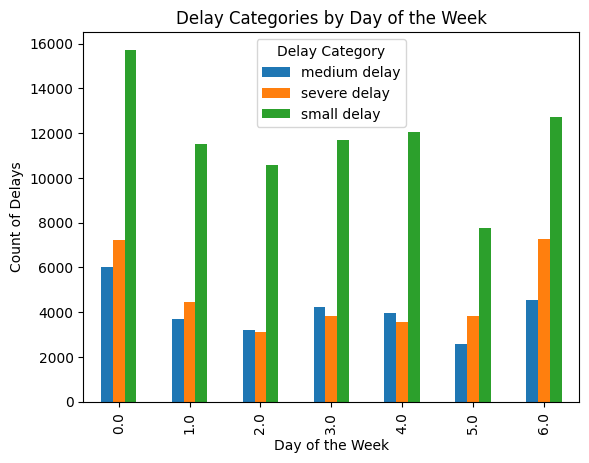

UNIQUE_CARRIER


DELTA_TIME                                                  \
DayOfWeek              0.0         1.0         2.0         3.0         4.0   
UNIQUE_CARRIER                                                               
AA              186.477690  203.562663  194.281584  188.161608  187.586270   
AS              167.464066  195.854911  155.951667  141.389953  135.521293   
B6               57.909673   88.379348  101.398027   87.048496   78.545196   
DL              146.735872  175.291496  175.848675  163.843924  174.956398   
EV              141.993255  143.831442  151.568403  152.603942  146.308321   
F9               92.609047  103.157948   91.226434   91.637843  122.027383   
HA              106.436677  124.883871  122.225032  119.966334  115.560185   
NK               80.995394   85.837357  127.852012  129.195031  145.091843   
OO              138.330401  146.622557  141.097717  144.513236  147.854242   
UA              180.156996  170.148822  199.619056  196.966420  187.555293   
VX              193.702840  154.837432  188.203779  190.149178  207.240202   
WN              130.648810  153.842037  154.735668  156.209116  163.101985   

                                        
DayOfWeek              5.0         6.0  
UNIQUE_CARRIER                          
AA              193.183831  159.385942  
AS              172.753557  116.011790  
B6               55.633813   39.269121  
DL              167.021424  100.072191  
EV              155.383420  134.898064  
F9              128.840838   92.625703  
HA              120.924939  113.444227  
NK              107.592643   88.877509  
OO              166.180760  136.311467  
UA              202.008073  128.702073  
VX              274.812261  138.292547  
WN              207.249171  120.998255

DEP_TIME_TO_STRING  \
UNIQUE_CARRIER ORIGIN_CITY_NAME DEST_CITY_NAME     FL_DATE                         
AA             Los Angeles, CA  New York, NY       2017-01-01               9:34   
                                                   2017-01-01              12:21   
                                                   2017-01-01              21:00   
                                                   2017-01-01              13:46   
                                                   2017-01-01              22:02   
...                                                                          ...   
DL             Los Angeles, CA  Seattle, WA        2017-01-31               8:57   
                                Salt Lake City, UT 2017-01-31              10:33   
                                Orlando, FL        2017-01-31              15:40   
                                Minneapolis, MN    2017-01-31               8:42   
                                Orlando, FL        2017-01-31              10:10   

                                                               DEP_DELAY  
UNIQUE_CARRIER ORIGIN_CITY_NAME DEST_CITY_NAME     FL_DATE                
AA             Los Angeles, CA  New York, NY       2017-01-01       34.0  
                                                   2017-01-01       51.0  
                                                   2017-01-01        0.0  
                                                   2017-01-01        6.0  
                                                   2017-01-01        2.0  
...                                                                  ...  
DL             Los Angeles, CA  Seattle, WA        2017-01-31       32.0  
                                Salt Lake City, UT 2017-01-31        8.0  
                                Orlando, FL        2017-01-31       -5.0  
                                Minneapolis, MN    2017-01-31       -3.0  
                                Orlando, FL        2017-01-31       -5.0  

[5330 rows x 2 columns]

ORIGIN_CITY_NAME,"Albuquerque, NM","Anchorage, AK","Aspen, CO","Atlanta, GA","Austin, TX","Baltimore, MD","Bend/Redmond, OR","Boise, ID","Boston, MA","Bozeman, MT",...,"San Luis Obispo, CA","Santa Barbara, CA","Seattle, WA","Spokane, WA","St. Louis, MO","Sun Valley/Hailey/Ketchum, ID","Tampa, FL","Tucson, AZ","Twin Falls, ID","Washington, DC"
FL_DATE,,,,,,,,,,,,,,,,,,,,,
2017-01-01,9.333333,-20.5,4.000000,19.625000,13.571429,1.333333,97.0,11.75,8.833333,28.0,...,4.00,-7.00,84.090909,NaN,15.00,20.0,-6.0,32.428571,NaN,14.437500
2017-01-02,31.800000,-4.0,136.666667,30.111111,26.250000,34.200000,96.0,34.00,31.000000,85.0,...,29.25,3.75,37.678571,NaN,28.50,NaN,40.0,28.750000,128.0,25.466667
2017-01-03,20.333333,25.0,55.000000,26.166667,16.625000,52.166667,40.0,59.75,23.727273,8.0,...,-13.75,-11.75,12.444444,NaN,37.20,16.0,12.0,16.000000,NaN,30.875000
2017-01-04,19.666667,86.5,39.666667,75.235294,13.333333,37.333333,NaN,86.00,9.500000,NaN,...,20.50,22.25,11.607143,NaN,21.20,NaN,16.0,25.000000,NaN,36.916667
2017-01-05,38.500000,-25.0,181.000000,79.555556,46.875000,31.000000,83.0,18.50,44.000000,NaN,...,42.25,55.00,69.333333,NaN,56.60,NaN,23.0,82.500000,NaN,30.538462
2017-01-06,162.500000,-9.5,24.000000,38.785714,32.125000,22.800000,35.0,141.50,22.272727,NaN,...,16.25,6.50,20.928571,NaN,17.80,NaN,112.0,22.714286,NaN,3.142857
2017-01-07,19.500000,5.5,51.200000,110.000000,9.166667,25.000000,33.0,51.50,48.285714,-2.0,...,12.00,6.00,36.761905,26.0,44.25,NaN,NaN,10.333333,89.0,13.818182


DayOfWeek,0.0,1.0,2.0,3.0,4.0,5.0,6.0
UNIQUE_CARRIER,,,,,,,
AA,12035,10339,9651,9854,9820,7905,11430
AS,2440,2261,1806,1935,1953,1762,2297
B6,4063,3681,3143,3258,3169,2643,3859
DL,12157,9784,9248,9695,9521,6492,10406
EV,5935,4943,4627,4923,4774,2905,5065
F9,1239,996,976,983,986,955,1245
HA,987,775,791,802,864,826,1022
NK,1954,1574,1616,1610,1563,1470,1946
OO,8321,6266,6413,6631,6667,4913,7409


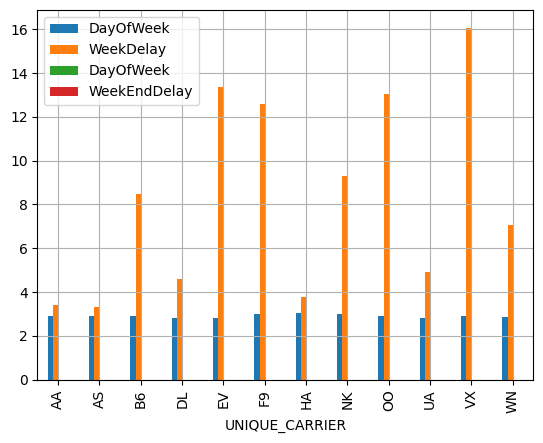

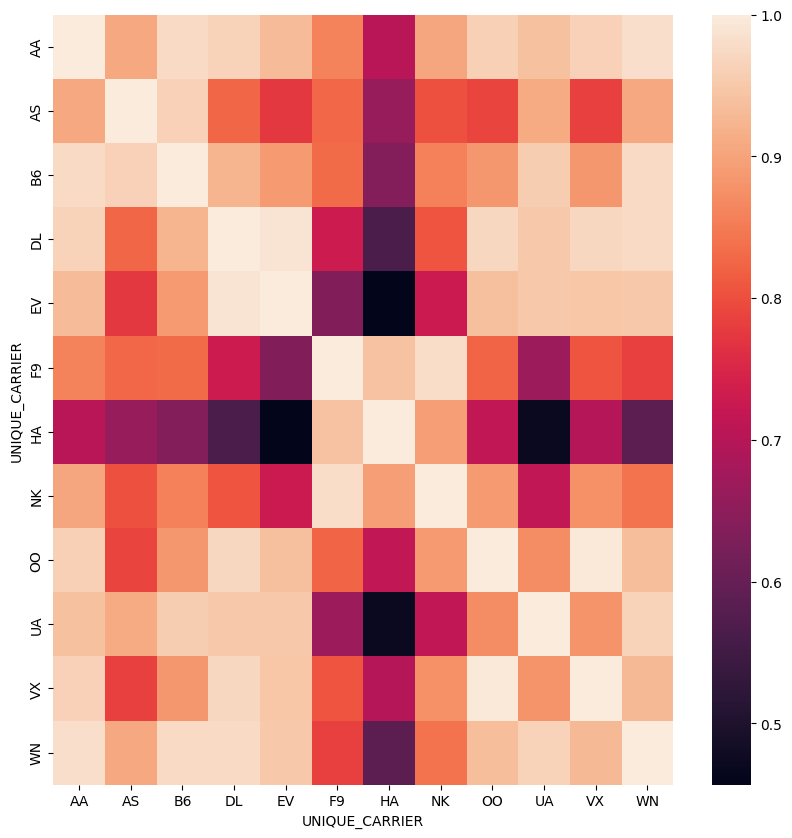

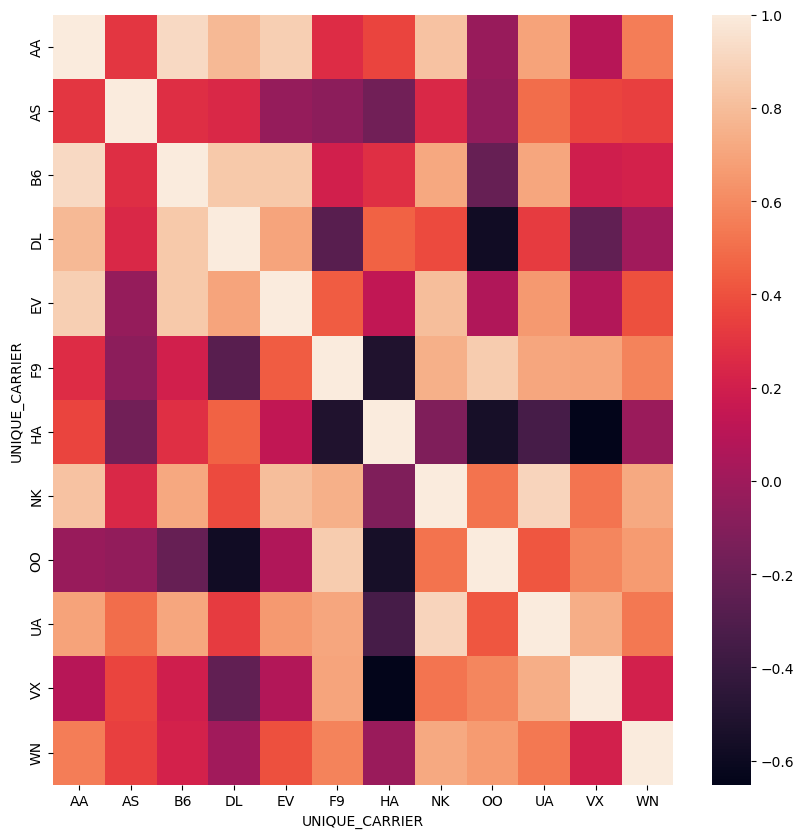

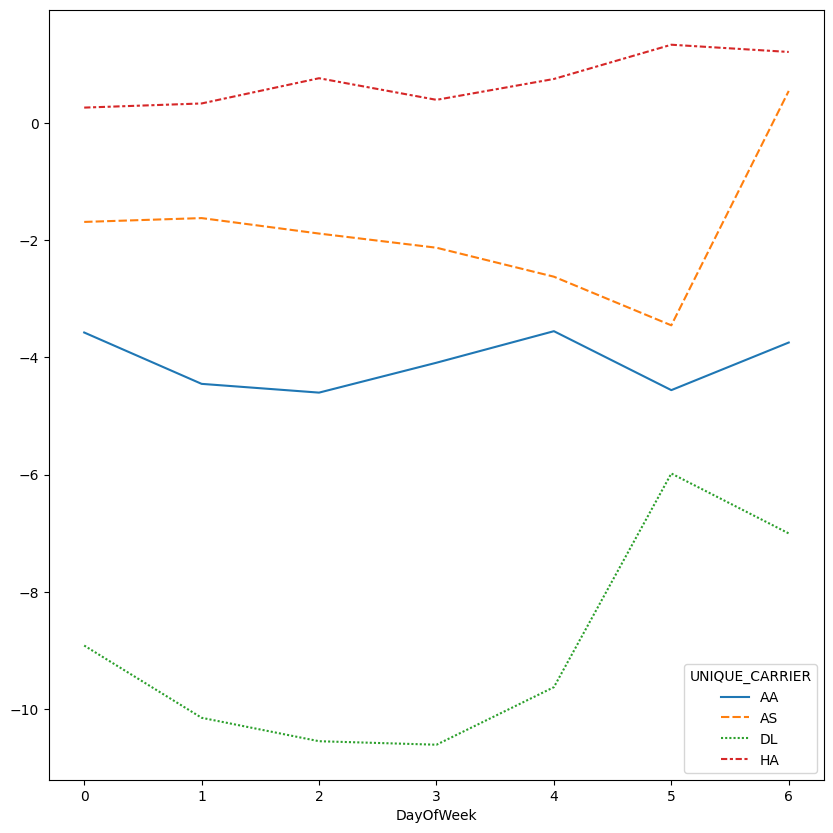

In [ ]:
def main()->None:
    df = readFileInputFlight(FLIGHT_DELAY_INPUT) # 1
    answerQuestion(df) # 2
    df = filterCancelFlight(df) # 3
    df = df.reindex(index=list(range(len(df))))
    queries(df) # 4
    addWeekDay(df) # 5
    addDelayDelta(df) # 5
    delayByDayOfWeek(df) # 6
    meanArrivalDelayTime(df, ['Saturday','Sunday'], 'ARR_DELAY') # 7
    meanArrivalArrivalTime(df, ['Saturday', 'Sunday']) # 7
    compareDelayByDayOfWeek(df,['Saturday', 'Sunday']) # 7
    df = multiIndex(df, ["UNIQUE_CARRIER", "ORIGIN_CITY_NAME", "DEST_CITY_NAME","FL_DATE"]) # 8
    queriesAAandDL(df) #9
    LAXDelayFirstWeek(df) # 10
    computePivotTablePlusHeatMap(df) # 11
    pivotTableAvgDelayArrival(df) # 12
    computeAndPlotAvgDeltaDelay(df, {'AA', 'DL', 'AS', 'HA'}) # 13
  
# main()